In [ ]:
import os
import tensorflow as tf
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array
import shutil


In [ ]:
# unzipping file
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/GunImages.zip", "r")
zip_ref.extractall("/content/GunImages")
zip_ref.close()

In [ ]:

# directories
train_dir = "/content/GunImages/weapon_detection/train/images"
validation_dir = "/content/GunImages/weapon_detection/val/images"

# Get a list of unique weapon types from the file names
weapon_types = set()
for filename in os.listdir(train_dir):
    weapon_type = filename.split('_')[0]
    weapon_types.add(weapon_type)

for weapon_type in weapon_types:
    # Create subdirectories
    train_subdir = os.path.join(train_dir, weapon_type)
    val_subdir = os.path.join(validation_dir, weapon_type)
    os.makedirs(train_subdir, exist_ok=True)
    os.makedirs(val_subdir, exist_ok=True)

    # Move files in train directory
    for filename in os.listdir(train_dir):
        if filename.startswith(weapon_type) and filename != weapon_type: # Check to avoid moving the directory into itself
            src_path = os.path.join(train_dir, filename)
            dst_path = os.path.join(train_subdir, filename)
            shutil.move(src_path, dst_path)

    # Move files in val directory (assuming similar naming convention)
    for filename in os.listdir(validation_dir): # Use 'validation_dir' instead of potentially undefined 'val_dir'
        if filename.startswith(weapon_type) and filename != weapon_type: # Check to avoid moving the directory into itself
            src_path = os.path.join(validation_dir, filename)
            dst_path = os.path.join(val_subdir, filename)
            shutil.move(src_path, dst_path)

print("Files moved to subdirectories successfully!")
print("Subdirectories created successfully!")


Files moved to subdirectories successfully!
Subdirectories created successfully!


In [ ]:

# imgs will be output in a 4x4 config
nrows = 4
ncols = 4

# to iterate over imgs
pic_index = 0

In [ ]:
plt.figure(figsize=(4, 4))
fig = plt.gcf()
fig.set_size_inches(ncols, nrows)

# get the file names of the images in the training dir
image_files = os.listdir(train_dir)

# select a subset of image files
selected_imgs = image_files[pic_index - 8: pic_index]

pic_index += 8
next_gun_pic = [os.path.join(train_dir, fname)
                for fname in selected_imgs]
for i, imgPath in enumerate(next_gun_pic):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis("off")

    img = mpimg.imread(imgPath)
    plt.imshow(img)

plt.show()

<Figure size 400x400 with 0 Axes>

In [ ]:
train_dataGen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                                rotation_range=60,
                                                                width_shift_range=0.3,
                                                                height_shift_range=0.3,
                                                                shear_range=0.3,
                                                                zoom_range=0.3,
                                                                horizontal_flip=True,
                                                                brightness_range=[0.7, 1.3],  # Adjust brightness
                                                                channel_shift_range=50.0,
                                                                fill_mode='nearest')

train_generator = train_dataGen.flow_from_directory("/content/GunImages/weapon_detection/train/images",
                                                    batch_size = 32,
                                                    class_mode = "sparse",
                                                    target_size = (300, 300))
validation_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255.)
validation_generator = validation_gen.flow_from_directory("/content/GunImages/weapon_detection/val/images",
                                                    batch_size = 32,
                                                    class_mode = "sparse",
                                                    target_size = (300, 300))
num_train_samples = len(train_generator.filenames)
num_val_samples = len(validation_generator.filenames)
print(num_train_samples)
print(num_val_samples)
steps_per_epoch = num_train_samples // 32
validation_steps = num_val_samples // 32

Found 571 images belonging to 9 classes.
Found 143 images belonging to 9 classes.
571
143


In [ ]:
# Load the pre-trained SSD MobileNet model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(300, 300, 3),  # Adjust input shape as needed
    include_top=False,  # Exclude the classification head
    weights='imagenet'
)
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation = "relu", kernel_regularizer = tf.keras.regularizers.l2(.1)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(9, activation = "softmax")
])

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 10, 10, 1280)      2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 9)                 2

Finding most optimal learning rate

In [ ]:


lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch/100)
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation loss
    patience= 10,           # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the weights of the best epoch
)

history = model.fit(train_generator, epochs = 30,
                    steps_per_epoch = steps_per_epoch,
                    validation_data = validation_generator,
                    validation_steps= validation_steps,
                    verbose = 1,
                    callbacks = [early_stopping, lr_schedule])

Epoch 1/30
17/17 [==============================] - 26s 1s/step - loss: 43.3819 - accuracy: 0.4669 - val_loss: 43.9476 - val_accuracy: 0.2734 - lr: 1.0000e-04
Epoch 2/30
17/17 [==============================] - 27s 2s/step - loss: 40.0486 - accuracy: 0.9518 - val_loss: 42.5913 - val_accuracy: 0.2734 - lr: 1.0233e-04
Epoch 3/30
17/17 [==============================] - 27s 2s/step - loss: 37.7441 - accuracy: 0.9814 - val_loss: 40.4917 - val_accuracy: 0.2969 - lr: 1.0471e-04
Epoch 4/30
17/17 [==============================] - 26s 2s/step - loss: 35.5534 - accuracy: 0.9759 - val_loss: 38.0002 - val_accuracy: 0.3359 - lr: 1.0715e-04
Epoch 5/30
17/17 [==============================] - 26s 2s/step - loss: 33.4306 - accuracy: 0.9759 - val_loss: 35.6528 - val_accuracy: 0.3516 - lr: 1.0965e-04
Epoch 6/30
17/17 [==============================] - 26s 2s/step - loss: 31.3875 - accuracy: 0.9852 - val_loss: 33.5257 - val_accuracy: 0.3906 - lr: 1.1220e-04
Epoch 7/30
17/17 [============================

(1e-08, 0.001, 0.0, 100.0)

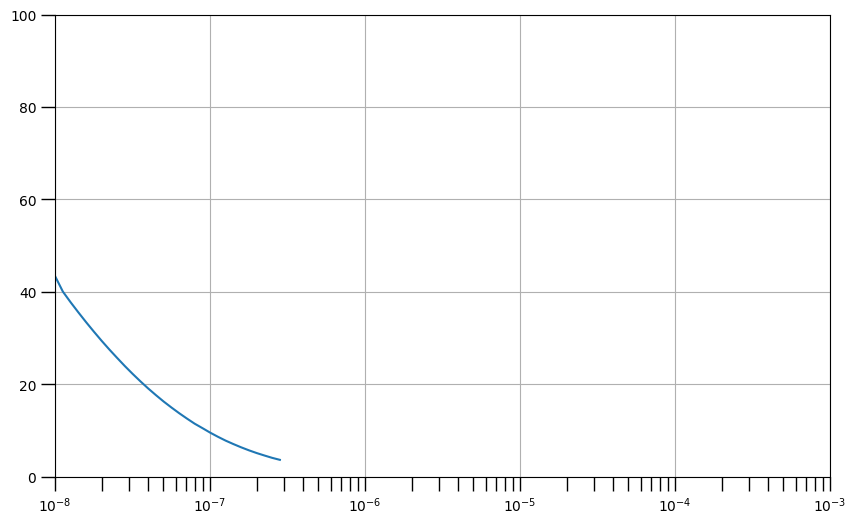

In [ ]:

lrs = 1e-8 * (10 ** (np.arange(len(history.history["loss"])) / 20)) # Use the length of the history loss to define the length of the lrs

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"]) # Now the lrs and loss have the same dimension

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

In [ ]:
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation = "relu", kernel_regularizer = tf.keras.regularizers.l2(.1)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(9, activation = "softmax")
])

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1.9e-4),
              metrics = ['accuracy'])

history = model.fit(train_generator, epochs = 30,
                    steps_per_epoch = steps_per_epoch,
                    validation_data = validation_generator,
                    validation_steps= validation_steps,
                    verbose = 1,
                    )

Epoch 1/30
 2/17 [==>...........................] - ETA: 19s - loss: 45.0196 - accuracy: 0.1094 

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


17/17 [==============================] - 34s 2s/step - loss: 42.5397 - accuracy: 0.2839 - val_loss: 39.8464 - val_accuracy: 0.3281
Epoch 2/30
17/17 [==============================] - 27s 2s/step - loss: 37.4631 - accuracy: 0.4861 - val_loss: 35.3470 - val_accuracy: 0.3984
Epoch 3/30
17/17 [==============================] - 27s 2s/step - loss: 32.9250 - accuracy: 0.6030 - val_loss: 31.1330 - val_accuracy: 0.5078
Epoch 4/30
17/17 [==============================] - 26s 2s/step - loss: 28.8741 - accuracy: 0.6976 - val_loss: 27.4368 - val_accuracy: 0.5469
Epoch 5/30
17/17 [==============================] - 27s 2s/step - loss: 25.3986 - accuracy: 0.7588 - val_loss: 24.1953 - val_accuracy: 0.5781
Epoch 6/30
17/17 [==============================] - 25s 1s/step - loss: 22.2164 - accuracy: 0.7811 - val_loss: 21.4032 - val_accuracy: 0.5781
Epoch 7/30
17/17 [==============================] - 26s 2s/step - loss: 19.4707 - accuracy: 0.8108 - val_loss: 18.7892 - val_accuracy: 0.6406
Epoch 8/30
17/17 

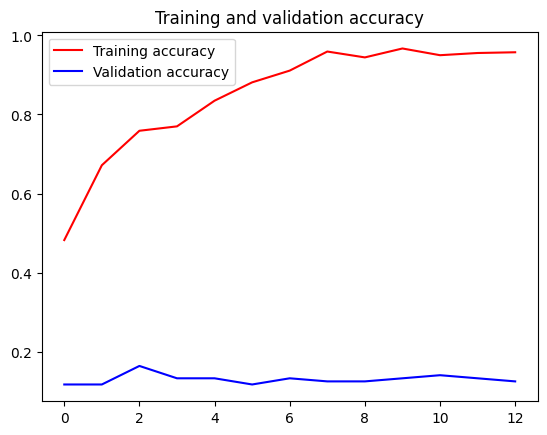

<Figure size 640x480 with 0 Axes>

In [ ]:

# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

1/1 [==============================] - 0s 88ms/step


<ipython-input-14-448724075e52>:38: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(display_grid, aspect='auto', cmap='viridis')


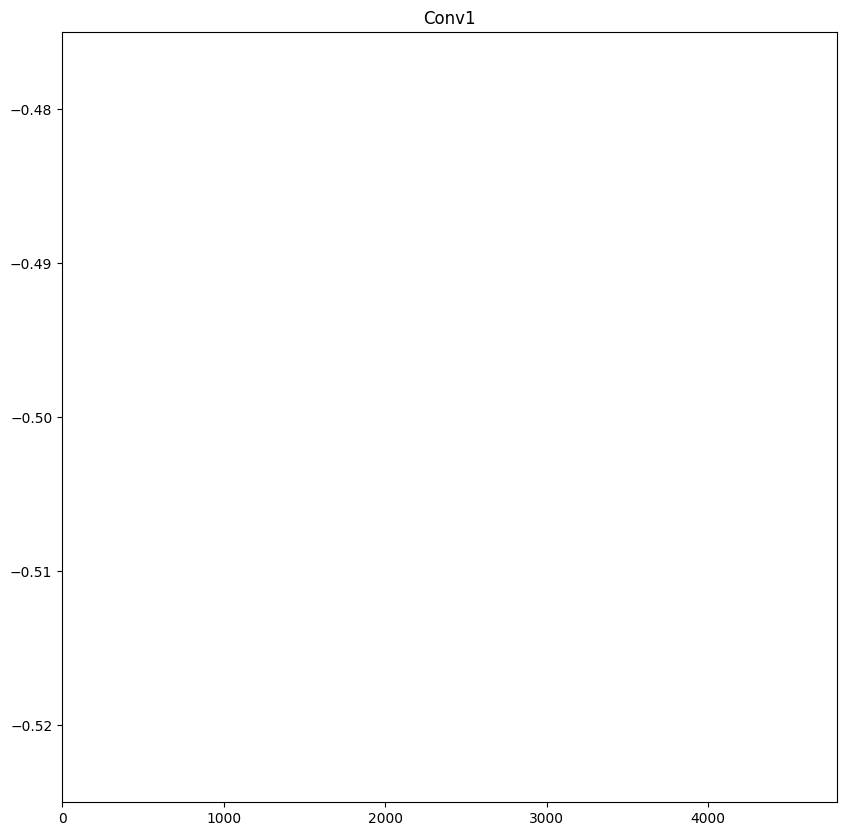

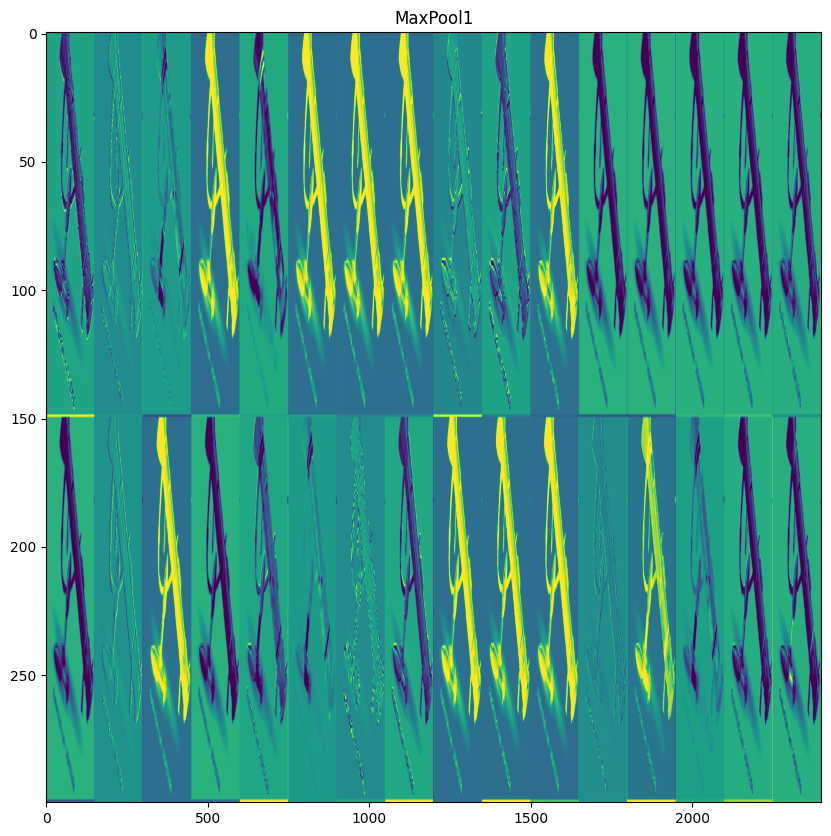

<ipython-input-14-448724075e52>:29: RuntimeWarning: divide by zero encountered in divide
  channel_image /= channel_image.std()
<ipython-input-14-448724075e52>:29: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
<ipython-input-14-448724075e52>:32: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


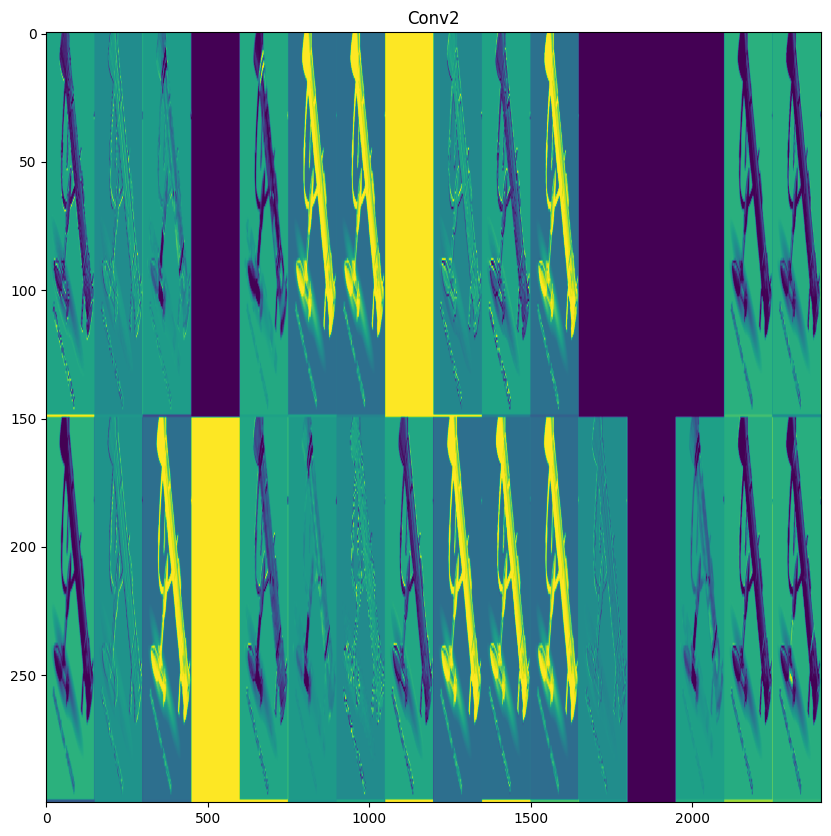

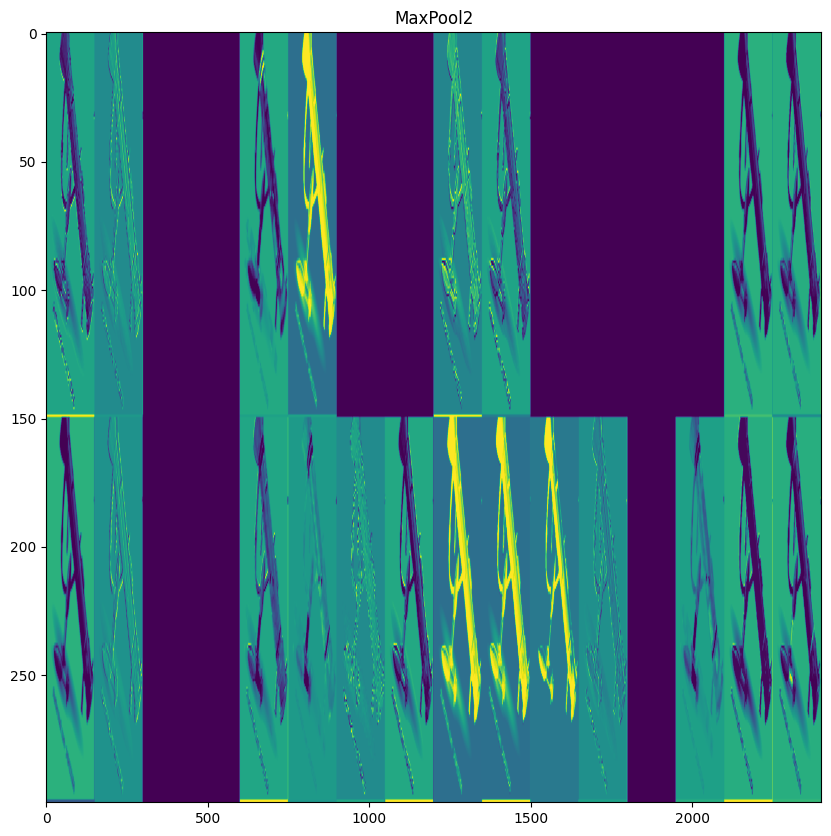

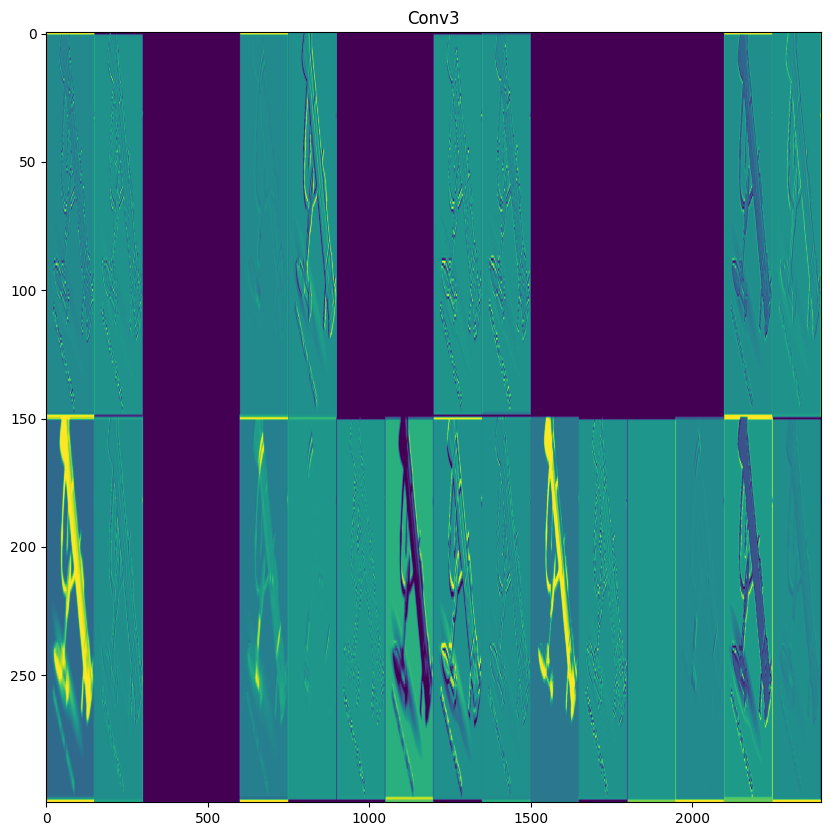

In [ ]:

# Extract the outputs of the convolutional layers
layer_outputs = [base_model.layers[i].output for i in range(5)]  # Adjust the index to include desired layers

# Create a model that will return these outputs, given the model input
activation_model = tf.keras.models.Model(inputs=base_model.input, outputs=layer_outputs)

# Choose an image from the generator (or load one manually)
img, label = train_generator.next()
img = img[0]  # Take the first image from the batch

# Reshape the image to match the model input
img_tensor = np.expand_dims(img, axis=0)

# Get the activations for the chosen image
activations = activation_model.predict(img_tensor)

# Plot the activations for each layer
layer_names = ['Conv1', 'MaxPool1', 'Conv2', 'MaxPool2', 'Conv3']  # Adjust names accordingly
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // 16
    display_grid = np.zeros((size * n_cols, 16 * size))
    for col in range(n_cols):
        for row in range(16):
            channel_image = layer_activation[0, :, :, col * 16 + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
            # Display the grid
    plt.figure(figsize=(10, 10))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()

In [ ]:


uploaded = files.upload()

class_names = ['Automatic Rifle', 'Bazooka', 'Handgun', 'Knife', 'SMG', 'Shotgun', 'Sniper', 'Sword', 'Grenade Launcher' ]

for fn in uploaded.keys():

  path = '/content/' + fn
  img = load_img(path, target_size = (300,300))

  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis = 0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size = 10)
  predicted_class_index = np.argmax(classes[0])
  predicted_class_name = class_names[predicted_class_index]

  print(f"The image {fn} is predicted to be: {predicted_class_name}")

Saving HandGun.jpg to HandGun.jpg
1/1 [==============================] - 1s 743ms/step
The image HandGun.jpg is predicted to be: Shotgun
